# Poda de ELM utilizando o Algoritmo das Projeções Sucessivas

Como o APS foi proposto como método de seleção de variáveis em problemas de regressão linear múltipla, é direta a sua aplicação na poda de neurônios da camada escondida de ELMs, uma vez que a projeção dos dados entre essa camada e a saída é equivalente a uma regressão linear múltipla.

Desse modo, o APS selecionará colunas da matriz H, cada uma sendo referente a um neurônio, de acordo com a ortogonalidade entre elas. É esperado que seja diminuído o overfitting do modelo com a poda, então deve-se iniciar a rede com muitos neurônios para comparar o desempenho antes e depois da poda.

In [91]:
# Bibliotecas necessárias
import numpy as np
import matplotlib.pyplot as plt
import scienceplots
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split
import importlib

# Estilo para os plots
plt.style.use(['grid', 'science', 'notebook'])

import elm
import aps_utils
importlib.reload(elm)
importlib.reload(aps_utils)
from elm import *
from aps_utils import *

---

## Teste em problema de regressão

In [111]:
# Carregar a base de dados (neste caso, dados de regressão relacionados a diabetes)
regression_data = load_diabetes()
x_reg = regression_data.data
y_reg = regression_data.target

# Separar em conjuntos de treinamento e teste (é importante separar ANTES
# de normalizar, pois não teríamos acesso aos dados de teste de antemão
# na vida real)
x_reg_train, x_reg_test, y_reg_train, y_reg_test = train_test_split(x_reg, y_reg, test_size=0.3, random_state=2003)

# Normalizar os dados entre -1 e 1
x_reg_train_norm, x_reg_test_norm = normalize_by_train(x_reg_train, x_reg_test)
y_reg_train_norm, y_reg_test_norm = normalize_by_train(y_reg_train, y_reg_test)

### Avaliação do erro de treinamento antes da poda

Há 442 amostras no dataset utilizado, então minha rede final pode ter, no máximo, 441 neurônios, pela limitação clássica do APS. Esse valor já é mais do que suficiente para sobreajustar a rede, pois 100 neurônios, nos meus testes anteriores, retornavam um bom modelo.

Como vou utilizar dados de validação no SPA, esse número será um pouco menor, mas ainda deve ser o suficiente para ser utilizado como tamanho máximo da rede.

MSE de treinamento: 1.0762471019769139e-27


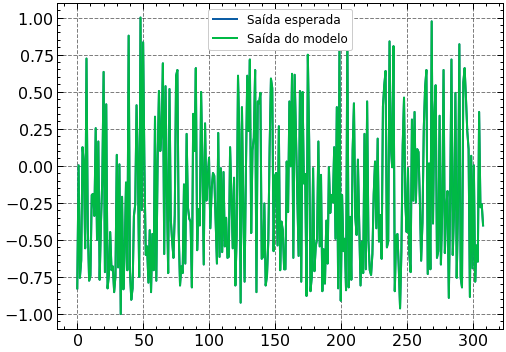

In [112]:
# Treinamento da ELM
n_neurons = x_reg.shape[0]
Z_reg, H_reg, W_reg = train_elm(x_reg_train_norm, y_reg_train_norm, n_neurons, 'lstsq')

# Saída do treinamento (a saída da ELM é linear, então não preciso transformar os dados em problemas
# de regressão)
yhat_reg_train = H_reg@W_reg

# Avaliação do modelo
plt.plot(y_reg_train_norm)
plt.plot(yhat_reg_train)
plt.legend(['Saída esperada', 'Saída do modelo'], loc='best', frameon='True', fontsize=12)
MSE_train = np.mean((y_reg_train_norm - yhat_reg_train)**2, axis=0)
print(f"MSE de treinamento: {MSE_train}")
plt.show()

Observa-se que o erro de treinamento foi praticamente zero (na ordem de 1e-27), o que indica que o modelo se sobreajustou aos dados de treinamento.

### Avaliação do erro de teste antes da poda

MSE de teste: 3.7217100864126866


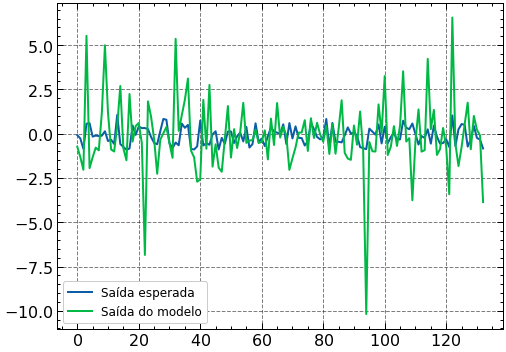

In [113]:
# Teste do modelo
yhat_reg_test = test_elm(x_reg_test_norm, Z_reg, W_reg)

# Avaliação do modelo
plt.plot(y_reg_test_norm)
plt.plot(yhat_reg_test)
plt.legend(['Saída esperada', 'Saída do modelo'], loc='best', frameon='True', fontsize=12)
MSE_test = np.mean((y_reg_test_norm - yhat_reg_test)**2, axis=0)
print(f"MSE de teste: {MSE_test}")
plt.show()

Como esperado, o erro de teste foi muito alto devido ao overfitting. Agora, vou aplicar a poda e avaliar novamente o resultado.

---

## Poda da rede

Vou utilizar as rotinas desenvolvidas para o APS para podar a rede desenvolvida. Para isso, vou colocar como entrada do modelo a matriz H da ELM inicial.

In [114]:
# Divisão dos dados de treinamento em calibração e validação
#
# Nesse caso, 30% dos dados são destinados para validação.
xcal, xval, ycal, yval = train_test_split(H_reg, y_reg_train_norm, test_size=0.2, random_state=0)

Projections:   0%|          | 0/442 [00:00<?, ?it/s]

Evaluation of variable subsets: 100%|██████████| 442/442 [08:26<00:00,  1.15s/it]


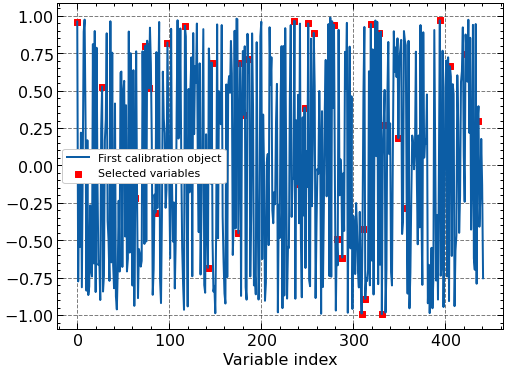


Neurônios selecionados: [394 313 179 423 117 333 247 279 177 310 146 349 282 175  27 257 142  74
  98 358 251 319 309 187 288  85 405 331 236 181  63 301  78 239   0 328
 435]


In [115]:
# Execução das duas primeiras fases do SPA
#
# O autor original utiliza a terceira fase também, mas ela não é interessante ainda
# para as aplicações que eu quero dar para o algoritmo
#
# SEL é o conjunto de variáveis selecionadas
SEL = spa(xcal, ycal, 
        M_min=1, M_max=xcal.shape[0]-1,
        xval=xval, yval=yval,
        plot=True)
print(f"\nNeurônios selecionados: {SEL}")

### Retreinamento da rede podada

MSE de treinamento: 0.2059602268030596


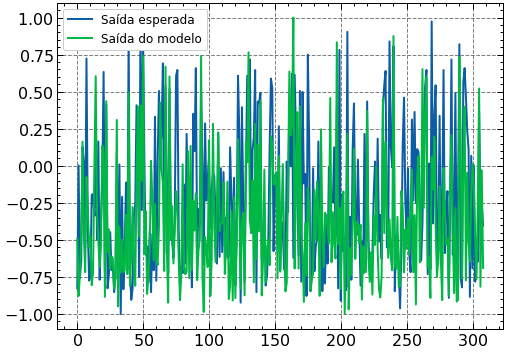

In [131]:
# É necessário obter uma nova matriz de pesos W para a camada de saída após a poda, pois os neurônios
# não são necessariamente independentes
H_pruned_spa, W_pruned_spa = train_pruned_elm(y_reg_train_norm, H_reg, SEL, learning='hebb')

# Normalizando pesos do modelo 
yhat_train_pruned_spa = H_pruned_spa @ W_pruned_spa
yhat_train_pruned_spa = 2*(yhat_train_pruned_spa - np.min(yhat_train_pruned_spa))/(np.max(yhat_train_pruned_spa) - np.min(yhat_train_pruned_spa)) - 1

# Avaliação do modelo
plt.plot(y_reg_train_norm)
plt.plot(yhat_train_pruned_spa)
plt.legend(['Saída esperada', 'Saída do modelo'], loc='best', frameon='True', fontsize=12)
MSE_train_pruned = np.mean((y_reg_train_norm - yhat_train_pruned_spa)**2, axis=0)
print(f"MSE de treinamento: {MSE_train_pruned}")
plt.show()

Observa-se que foi gerada uma nova solução, dessa vez com erro diferente de zero

### Teste da rede podada

MSE de teste: 0.22498067696173288


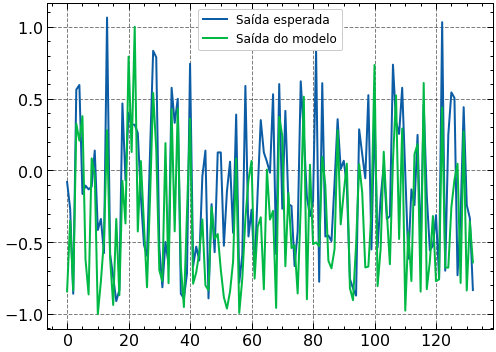

In [132]:
yhat_test_pruned_spa = test_pruned_elm(x_reg_test_norm, Z_reg, W_pruned_spa, SEL)
yhat_test_pruned_spa = 2*(yhat_test_pruned_spa - np.min(yhat_test_pruned_spa))/(np.max(yhat_test_pruned_spa) - np.min(yhat_test_pruned_spa)) - 1

# Avaliação do modelo
plt.plot(y_reg_test_norm)
plt.plot(yhat_test_pruned_spa)
plt.legend(['Saída esperada', 'Saída do modelo'], loc='best', frameon='True', fontsize=12)
MSE_test_pruned = np.mean((y_reg_test_norm - yhat_test_pruned_spa)**2, axis=0)
print(f"MSE de teste: {MSE_test_pruned}")
plt.show()

O modelo podado, mesmo com menos neurônios, foi capaz de gerar uma solução com erro baixo para o conjunto de teste

### Teste de rede com poda aleatória

Ainda é necessário verificar se a poda pelo APS funciona melhor que uma poda aleatória. Para tal, vou gerar uma nova rede podada aleatoriamente com a mesma quantidade de neurônios que a rede podada pelo APS.

Como os neurônios são selecionados aleatoriamente, é necessário calcular diversas vezes o desempenho do modelo para poder tirar conclusões acerca dos resultados.

In [125]:
n_tests = 400
train_mse_history = np.zeros(n_tests)
test_mse_history = np.zeros(n_tests)

for i in range(n_tests):
    # Novo conjunto de neurônios selecionados é aleatório (devem ser selecionados sem reposição)
    M_random = SEL.shape[0]
    SEL_random = np.random.choice(H_reg.shape[1]-1, M_random, replace=False)

    # É necessário obter uma nova matriz de pesos W para a camada de saída após a poda, pois os neurônios
    # não são necessariamente independentes
    H_pruned_random, W_pruned_random = train_pruned_elm(y_reg_train_norm, H_reg, SEL_random, learning='hebb')
    yhat_train_pruned_random = H_pruned_random @ W_pruned_random
    yhat_train_pruned_random = 2*(yhat_train_pruned_random - np.min(yhat_train_pruned_random))/(np.max(yhat_train_pruned_random) - np.min(yhat_train_pruned_random)) - 1

    # Teste da rede
    yhat_test_pruned_random = test_pruned_elm(x_reg_test_norm, Z_reg, W_pruned_random, SEL_random)
    yhat_test_pruned_random = 2*(yhat_test_pruned_random - np.min(yhat_test_pruned_random))/(np.max(yhat_test_pruned_random) - np.min(yhat_test_pruned_random)) - 1
    
    # Adicionar aos vetores os resultados atuais
    train_mse_history[i] = np.mean((y_reg_train_norm - yhat_train_pruned_random)**2, axis=0)
    test_mse_history[i] =  np.mean((y_reg_test_norm - yhat_test_pruned_random)**2, axis=0)
    
mean_train_mse_random = np.mean(train_mse_history)
std_train_mse_random = np.std(train_mse_history)
mean_test_mse_random = np.mean(test_mse_history)
std_test_mse_random = np.std(test_mse_history)

print(f"""MSE médio de treinamento: {round(mean_train_mse_random, 4)}
Desvio-padrão do MSE do treinamento: {round(std_train_mse_random, 4)}
MSE mínimo do treinamento: {round(np.min(train_mse_history), 4)}
MSE máximo do treinamento: {round(np.max(train_mse_history), 4)}

MSE médio de teste: {round(mean_test_mse_random, 4)}
Desvio-padrão do MSE do teste: {round(std_test_mse_random, 4)}
MSE mínimo do teste: {round(np.min(test_mse_history), 4)}
MSE máximo do teste: {round(np.max(test_mse_history), 4)}""")

MSE médio de treinamento: 0.1143
Desvio-padrão do MSE do treinamento: 0.0082
MSE mínimo do treinamento: 0.0993
MSE máximo do treinamento: 0.1497

MSE médio de teste: 0.1375
Desvio-padrão do MSE do teste: 0.0131
MSE mínimo do teste: 0.1118
MSE máximo do teste: 0.2251
